# IMPORTS

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import f1_score



## LEITURA DOS DADOS

In [2]:
df = pd.read_csv('/home/cid34senhas/Desktop/DAATP/RawData/train_radiomics_hipocamp.csv') 
df_test = pd.read_csv('/home/cid34senhas/Desktop/DAATP/RawData/test_radiomics_hipocamp.csv')

# Tratamento

### Single Value Colums 

In [3]:

print (len(df.nunique()[df.nunique() == 1]))
df = df.loc[:, df.nunique() > 1]
df_test = df_test.loc[:, df_test.nunique() > 1]


#  Analise das colunas que tem menos de 50 valores unicos 
#n = df.nunique()
#for col, e in n.items():
#    if e < 50:  
#        print(f"Coluna: {col}, Valores Unicos : {e}")

159


### AGE BINING  ( secalhar isto era no 2 )

In [4]:
print(df['Age'].dtype)

age_bins = [0, 65, 75, 85, 100]
# BINS_SIZER = ['<65', '65-74', '75-84', '85+']
age_labels = [60, 70, 80, 90] # VALOR MEDIO DO BIN 
df['Age'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels).astype(int)
df_test['Age'] = pd.cut(df_test['Age'], bins=age_bins, labels=age_labels).astype(int)

#print(df['Age'])

float64


### Colunas Categoricas 

In [5]:
# Analisar a contagem de valores únicos para cada coluna categórica

# Identificar as colunas categóricas
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

#for col in categorical_columns:
#    print(f"\nColuna: {col}")

#colunas_catagoricas_a_remover = ['ID', 'Image', 'Mask', 'diagnostics_Image-original_Hash', 'diagnostics_Mask-original_Hash'] 

colunas_catagoricas_a_remover = ['ID', 'Image', 'Mask', 'diagnostics_Image-original_Hash', 'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMassIndex', 'diagnostics_Mask-original_CenterOfMass'] 

# ** Bounding Box
#
# ** as colunas do 'diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMassIndex', 'diagnostics_Mask-original_CenterOfMass'
# ** Deveriam ser retiradas, mas o bounding box pode ser importante para a zona de maior ativação do Alzimeir 
# **  ja a de centro de maxima devem ser muito correlacionados, por isso devem ser retirados mais para a frente 
# *TODO acabei por retirar para correr melhor os modelos, mas analisar se se deve retirar ou nao 

df.drop(columns=colunas_catagoricas_a_remover,axis= 1 , inplace= True)
df_test.drop(columns=colunas_catagoricas_a_remover,axis= 1 , inplace= True)

### Label Encoding

In [6]:
label_mapping = {
    'CN-CN': 0,
    'AD-AD': 1,
    'MCI-AD': 2,
    'MCI-MCI': 3,
    'CN-MCI' : 4
}
# Apply the mapping to the target column
df['Transition'] = df['Transition'].map(label_mapping)

In [7]:
df.to_csv('DF_CN-MCI_1_After_Pre_Processamento.csv', index=False)
df_test.to_csv('DF_Test_1_After_Pre_Processamento.csv', index=False)


## Models

In [8]:

#experiment = setup(df, target='Transition')

In [9]:
#best = compare_models()

Com o tratamento atual, o pycaret diz que os melhores modelos são :
- Random Forest Classifier
- Extra Trees Classifier
- Gradient Boosting Classifier 
- K Neighbors Classifier
- Extreme Gradient Boosting 


### Aplicação dos modelos (default) ao dataset tratado

In [10]:
# Separar as features e o target
X = df.drop('Transition', axis=1)
y = df['Transition']


# Dividir o conjunto de dados em treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=34, stratify=y)


# Inicializar dicionário para armazenar as pontuações de cross-validation do modelo
model_cross_score = {}


## Dados Treino e Teste Normalizados

In [11]:
# Normalizar os dados usando StandardScaler
scaler = StandardScaler()

X__train_normalizado = scaler.fit_transform(X_train)
X_test_normalizado = scaler.transform(X_test)


### Funcao Axuliar: Matrix de Confusão

In [12]:
def plot_confusion_matrix_with_labels(confusion_matrix, label_mapping):
    # Criar um mapeamento inverso
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}
    
    # Aplicar o mapeamento inverso na matriz de confusão
    cm_with_labels = np.zeros_like(confusion_matrix, dtype=object)
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            cm_with_labels[i, j] = f"{reverse_label_mapping[i]} (Pred: {reverse_label_mapping[j]})"

    # Criar um DataFrame para facilitar a visualização
    df_cm = pd.DataFrame(confusion_matrix, index=reverse_label_mapping.values(), columns=reverse_label_mapping.values())
    
    # Plotar a matriz de confusão
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix with Labels')
    plt.show()

## Random Forest Classifier

### Score

/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

              precision    recall  f1-score   support

           0       0.57      0.71      0.63        24
           1       0.44      0.47      0.45        15
           2       0.10      0.12      0.11        17
           3       0.30      0.17      0.21        18
           4       0.00      0.00      0.00         3

    accuracy                           0.38        77
   macro avg       0.28      0.29      0.28        77
weighted avg       0.35      0.38      0.36        77



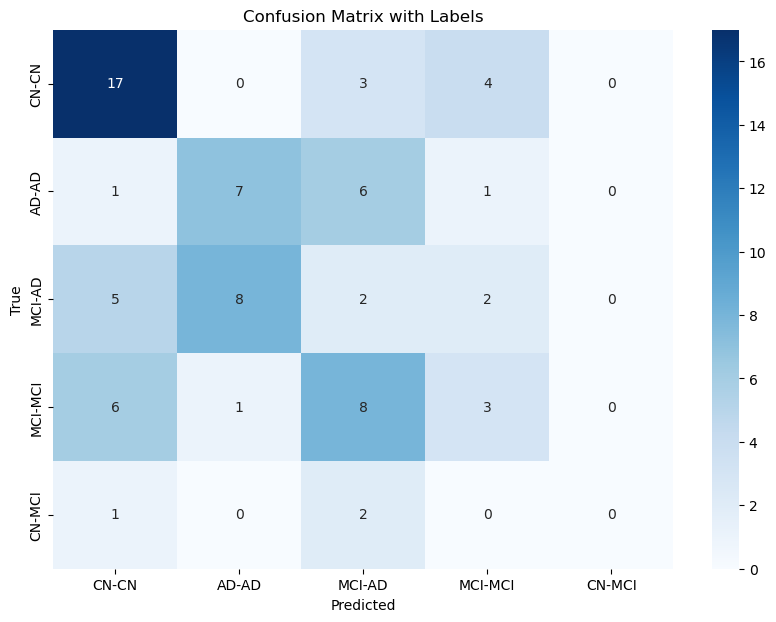

In [13]:
rf_model_score = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=34)


rf_model_score.fit(X_train, y_train)
rf_pred = rf_model_score.predict(X_test)
print(classification_report(y_test, rf_pred))
cm = confusion_matrix(y_test, rf_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)

### Cross Validation Score 

In [14]:

rf_model = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=34)

rf_score = cross_val_score(rf_model, X_train, y_train, cv=5,scoring='f1_macro').mean()

model_cross_score['random_forest'] = rf_score


## Extra Trees Classifier

### Score

              precision    recall  f1-score   support

           0       0.57      0.71      0.63        24
           1       0.38      0.53      0.44        15
           2       0.06      0.06      0.06        17
           3       0.30      0.17      0.21        18
           4       0.00      0.00      0.00         3

    accuracy                           0.38        77
   macro avg       0.26      0.29      0.27        77
weighted avg       0.33      0.38      0.35        77



/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

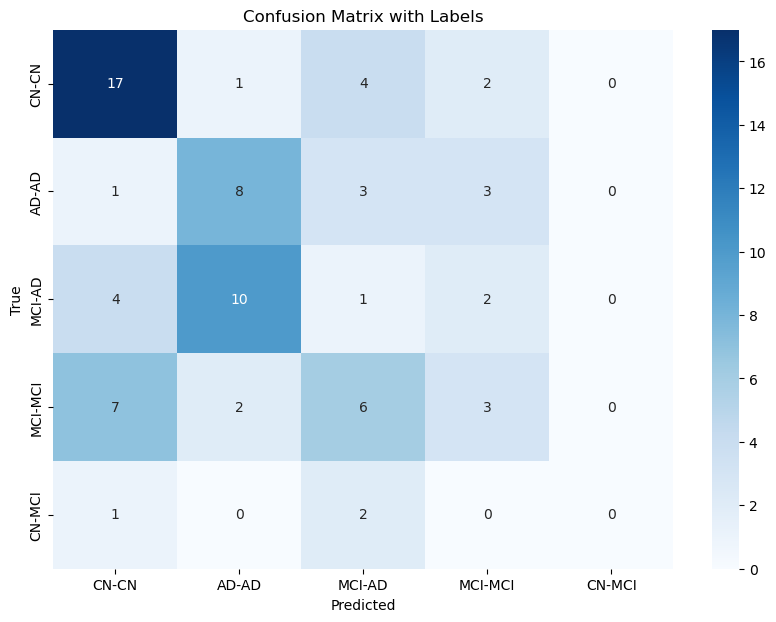

In [15]:
et_model_score = ExtraTreesClassifier(criterion='gini', max_depth=20, random_state=34)


et_model_score.fit(X_train, y_train)
et_pred = et_model_score.predict(X_test)
print(classification_report(y_test,et_pred))
cm = confusion_matrix(y_test,et_pred)
plot_confusion_matrix_with_labels(cm, label_mapping)


### Cross Validation Score

In [16]:
et_model = ExtraTreesClassifier(criterion='gini', max_depth=20, random_state=34)

model_cross_score['Extra Trees'] = cross_val_score(et_model, X_train, y_train, cv=5,scoring='f1_macro').mean()

print(model_cross_score['Extra Trees'])

0.29786562511084547


## Gradient Boosting Classifier 

### Score

              precision    recall  f1-score   support

           0       0.57      0.67      0.62        24
           1       0.57      0.53      0.55        15
           2       0.21      0.18      0.19        17
           3       0.16      0.17      0.16        18
           4       0.00      0.00      0.00         3

    accuracy                           0.39        77
   macro avg       0.30      0.31      0.30        77
weighted avg       0.37      0.39      0.38        77



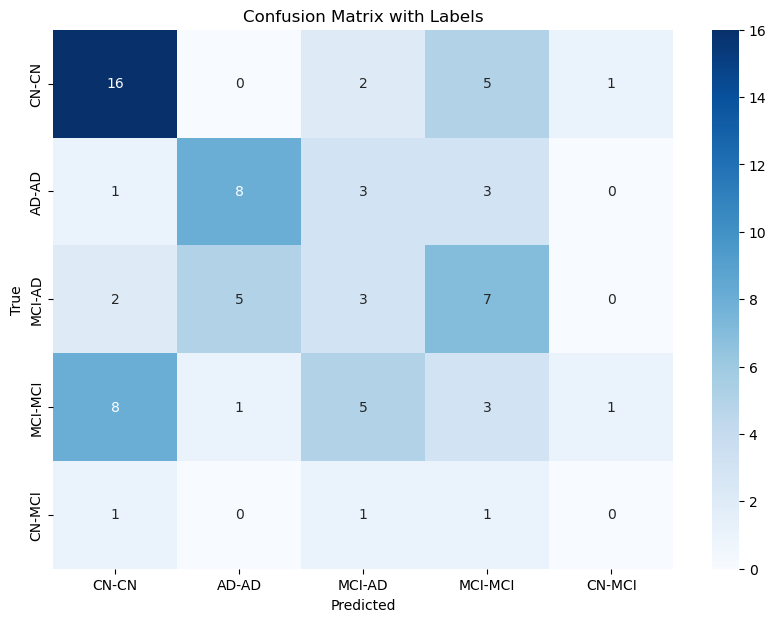

In [17]:
gb_model_score = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, random_state=34)


gb_model_score.fit(X_train, y_train)
gb_pred = gb_model_score.predict(X_test)
print(classification_report(y_test,gb_pred))
cm = confusion_matrix(y_test,gb_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)



### Cross Validation Score

In [18]:
gb_model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, random_state=34)

score_cross = cross_val_score(gb_model,X_train,y_train,cv=5,scoring='f1_macro').mean()

print(score_cross)

model_cross_score['Gradient_boosting'] = score_cross



0.31420832810852356


#### K Neighbors Classifier

### Score

              precision    recall  f1-score   support

           0       0.44      0.71      0.54        24
           1       0.29      0.40      0.33        15
           2       0.18      0.12      0.14        17
           3       0.50      0.17      0.25        18
           4       0.00      0.00      0.00         3

    accuracy                           0.36        77
   macro avg       0.28      0.28      0.25        77
weighted avg       0.35      0.36      0.32        77



/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

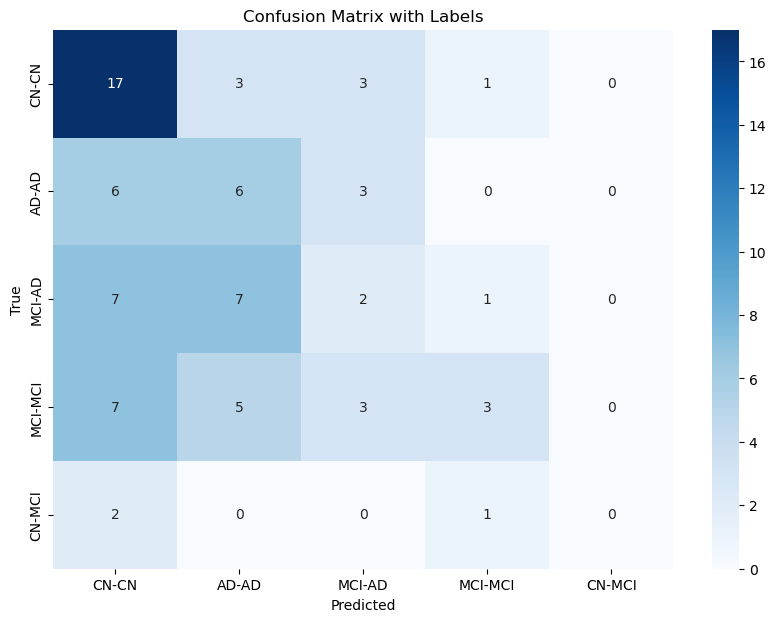

In [19]:
kn_model_score = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')


kn_model_score.fit(X_train, y_train)
kn_pred = kn_model_score.predict(X_test)
print(classification_report(y_test,kn_pred))
cm = confusion_matrix(y_test,kn_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)


### Cross Validation Score

In [20]:
kn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')

k_night_croos_score = cross_val_score(kn_model, X_train, y_train, cv=10,scoring='f1_macro')

print("Acuracy k night", k_night_croos_score.mean())

model_cross_score['k_night'] = k_night_croos_score.mean()


/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


Acuracy k night 0.33594415070653455


#### Extreme Gradient Boosting

### Score

              precision    recall  f1-score   support

           0       0.53      0.71      0.61        24
           1       0.53      0.53      0.53        15
           2       0.18      0.18      0.18        17
           3       0.31      0.22      0.26        18
           4       0.00      0.00      0.00         3

    accuracy                           0.42        77
   macro avg       0.31      0.33      0.32        77
weighted avg       0.38      0.42      0.39        77



/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

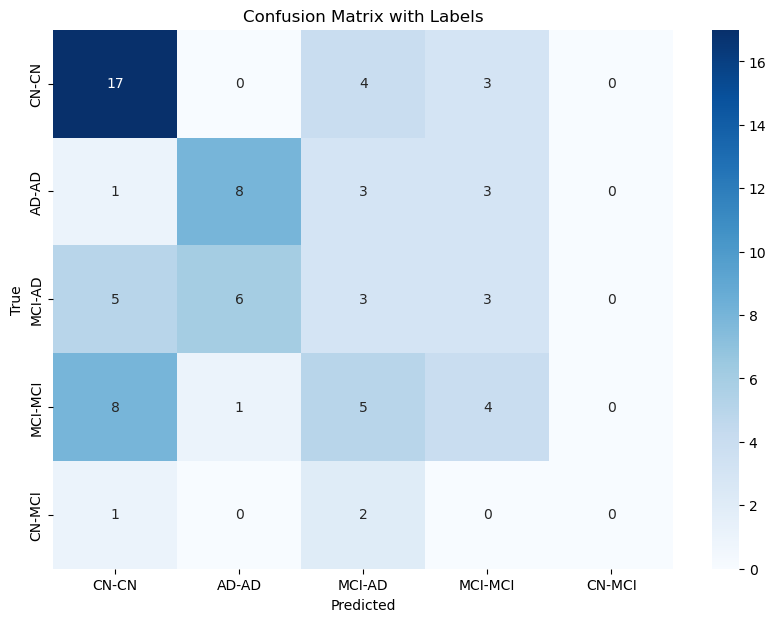

In [21]:
xgb_model_score = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05,colsample_bytree=0.4, subsample=0.8, random_state=34)



xgb_model_score.fit(X_train, y_train)
xgb_pred = xgb_model_score.predict(X_test)
print(classification_report(y_test,xgb_pred))
cm = confusion_matrix(y_test,xgb_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)





### Cross Validation Score

In [22]:
xgb_model = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05,colsample_bytree=0.4, subsample=0.8, random_state=34)


score_cross = cross_val_score(xgb_model,X_train,y_train,cv=5,scoring='f1_macro')

print(score_cross)
print(score_cross.std())
model_cross_score['XGBoost'] = score_cross.mean()



[0.35387488 0.25852474 0.30472965 0.21101449 0.3420499 ]
0.053205264219250085


## SVC

### Score

              precision    recall  f1-score   support

           0       0.53      0.71      0.61        24
           1       0.53      0.53      0.53        15
           2       0.18      0.18      0.18        17
           3       0.31      0.22      0.26        18
           4       0.00      0.00      0.00         3

    accuracy                           0.42        77
   macro avg       0.31      0.33      0.32        77
weighted avg       0.38      0.42      0.39        77



/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

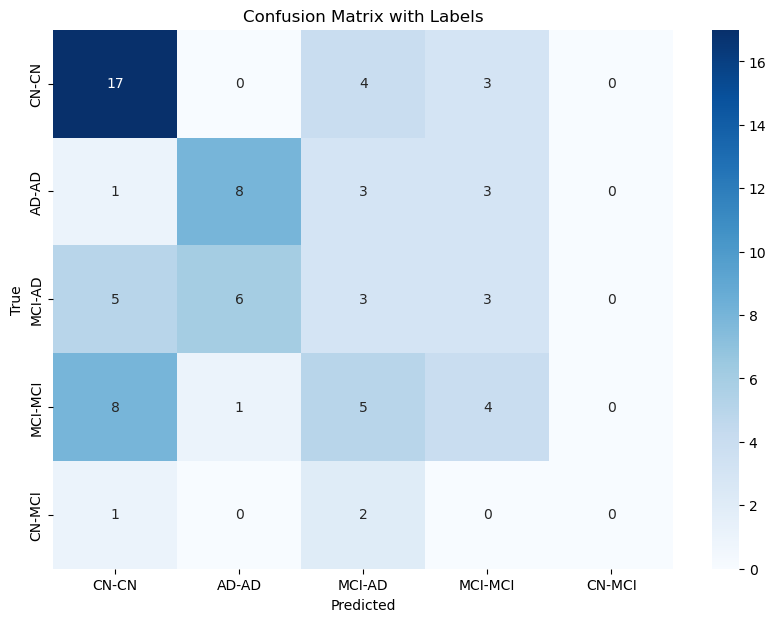

In [23]:
svc_moldel_score = SVC(kernel='rbf', random_state=34)



svc_moldel_score.fit(X_train, y_train)
svc_pred = svc_moldel_score.predict(X_test)
print(classification_report(y_test,xgb_pred))
cm = confusion_matrix(y_test,xgb_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)



### Cross Validation Score

In [24]:


svc_moldel = SVC(kernel='rbf', random_state=34)


score_cross = cross_val_score(xgb_model,X_train,y_train,cv=5,scoring='f1_macro').mean()

print(score_cross)

model_cross_score['SVC'] = score_cross



0.29403873381067375


Model                Accuracy
------------------------------
Extreme Gradient Boosting     0.4156
Gradient Boosting Classifier     0.3896
Support Vector Classification     0.3896
Random Forest Classifier     0.3766
Extra Trees Classifier     0.3766
K Neighbors Classifier     0.3636


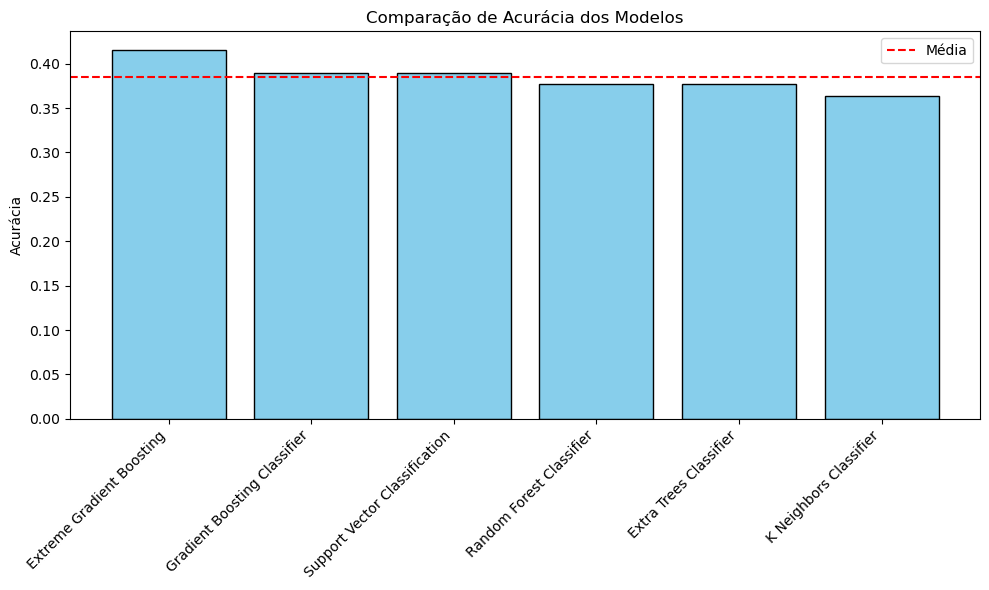

Model                F1-macro
------------------------------
Extreme Gradient Boosting     0.3150
Gradient Boosting Classifier     0.3046
Random Forest Classifier     0.2802
Extra Trees Classifier     0.2698
Support Vector Classification     0.2548
K Neighbors Classifier     0.2532


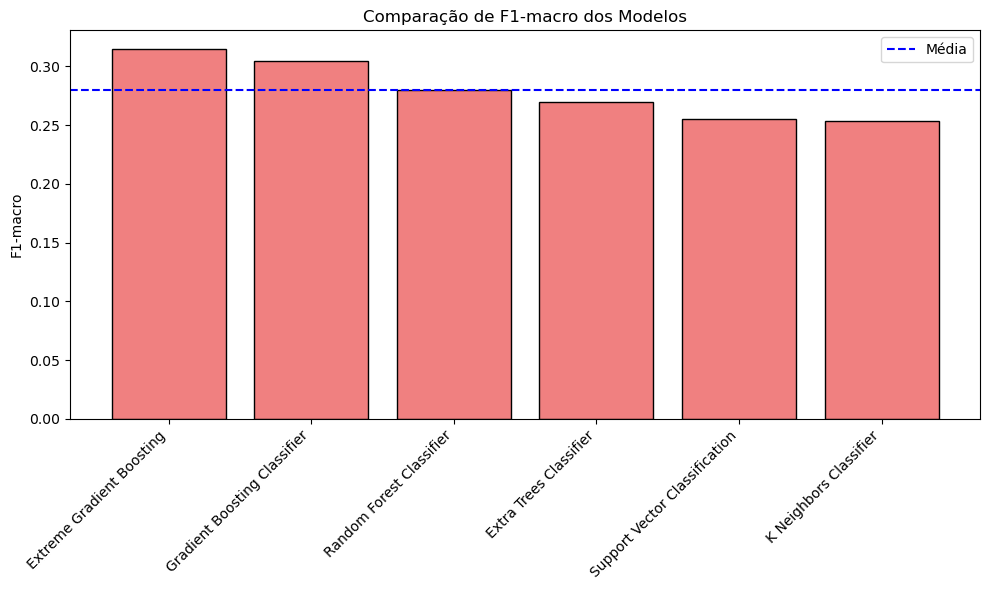

Model                          Cross-Validation Score
---------------------------------------------
k_night                            0.3359
random_forest                      0.3318
Gradient_boosting                  0.3142
Extra Trees                        0.2979
XGBoost                            0.2940
SVC                                0.2940


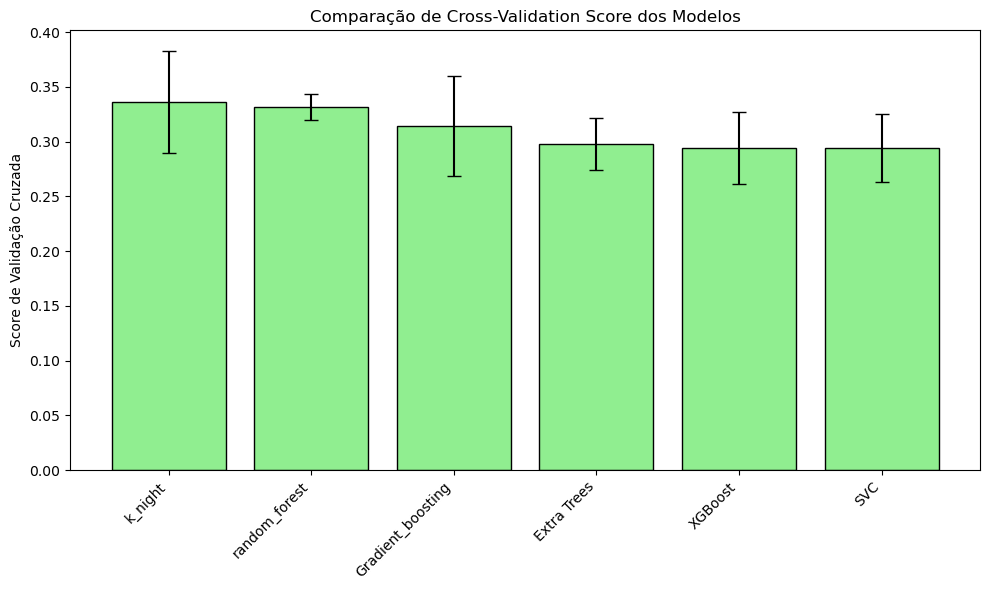

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Função para comparar modelos e criar gráfico com acurácia
def compare_models(Y_test, predictions):
    model_accuracies = {}

    # Calcular acurácia de cada modelo
    for name, prediction in predictions.items():
        accuracy = sum(prediction == Y_test) / len(Y_test)
        model_accuracies[name] = accuracy

    # Ordenar os modelos por acurácia em ordem decrescente
    sorted_models = sorted(model_accuracies.items(), key=lambda x: x[1], reverse=True)

    # Imprimir a tabela
    print("Model".ljust(20), "Accuracy")
    print("-" * 30)
    for model, accuracy in sorted_models:
        print(model.ljust(20), f"{accuracy:.4f}".rjust(10))

    # Gerar gráfico de barras
    models = [model for model, _ in sorted_models]
    accuracies = [accuracy for _, accuracy in sorted_models]

    plt.figure(figsize=(10, 6))
    plt.bar(models, accuracies, color="skyblue", edgecolor="black")
    plt.axhline(y=np.mean(accuracies), color='red', linestyle='--', label="Média")
    plt.title("Comparação de Acurácia dos Modelos")
    plt.ylabel("Acurácia")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Função para comparar scores de validação cruzada e criar gráfico
def compare_models_cross_score(model_cross_score):
    # Ordenar modelos por score em ordem decrescente
    sorted_models = sorted(model_cross_score.items(), key=lambda x: x[1], reverse=True)

    # Imprimir a tabela
    print("Model".ljust(30), "Cross-Validation Score")
    print("-" * 45)
    for model, score in sorted_models:
        print(model.ljust(30), f"{score:.4f}".rjust(10))

    # Gerar gráfico de barras com variância
    models = [model for model, _ in sorted_models]
    scores = [score for _, score in sorted_models]

    # Simulação de variância (se você já tiver, substitua pelo real)
    variances = np.random.uniform(0.01, 0.05, len(scores))

    plt.figure(figsize=(10, 6))
    plt.bar(models, scores, yerr=variances, capsize=5, color="lightgreen", edgecolor="black")
    plt.title("Comparação de Cross-Validation Score dos Modelos")
    plt.ylabel("Score de Validação Cruzada")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


def compare_models_f1_macro(Y_test, predictions):
    model_f1_scores = {}

    # Calcular o F1-macro para cada modelo
    for name, prediction in predictions.items():
        f1_macro = f1_score(Y_test, prediction, average='macro')
        model_f1_scores[name] = f1_macro

    # Ordenar os modelos por F1-macro em ordem decrescente
    sorted_models = sorted(model_f1_scores.items(), key=lambda x: x[1], reverse=True)

    # Imprimir a tabela
    print("Model".ljust(20), "F1-macro")
    print("-" * 30)
    for model, f1_macro in sorted_models:
        print(model.ljust(20), f"{f1_macro:.4f}".rjust(10))

    # Gerar gráfico de barras
    models = [model for model, _ in sorted_models]
    f1_scores = [f1_macro for _, f1_macro in sorted_models]

    plt.figure(figsize=(10, 6))
    plt.bar(models, f1_scores, color="lightcoral", edgecolor="black")
    plt.axhline(y=np.mean(f1_scores), color='blue', linestyle='--', label="Média")
    plt.title("Comparação de F1-macro dos Modelos")
    plt.ylabel("F1-macro")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Exemplo de uso
predictions = {
    'Random Forest Classifier': rf_pred,
    'Extra Trees Classifier': et_pred,
    'Gradient Boosting Classifier': gb_pred,
    'K Neighbors Classifier': kn_pred,
    'Extreme Gradient Boosting': xgb_pred,
    'Support Vector Classification' : svc_pred
}


compare_models(y_test, predictions)
compare_models_f1_macro(y_test, predictions)
compare_models_cross_score(model_cross_score)


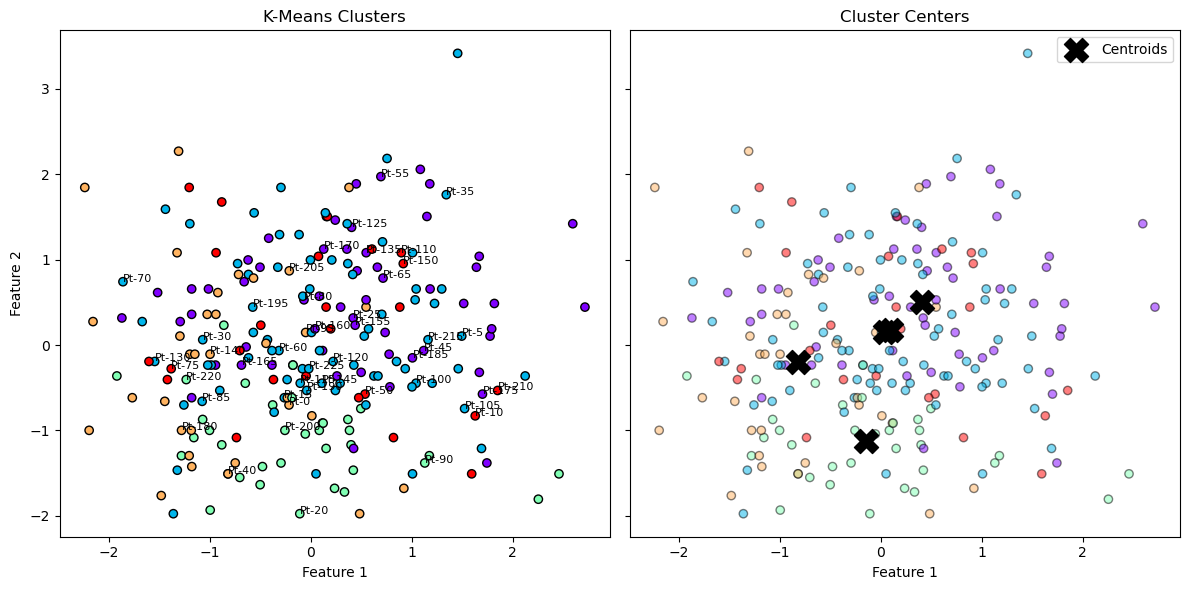

In [26]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Inicializar o modelo KMeans
kmeans = KMeans(n_clusters=5, n_init='auto', random_state=34)

kmeans.fit(X__train_normalizado)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))

# Primeiro gráfico - clusters identificados pelo KMeans
ax1.set_title('K-Means Clusters')
scatter = ax1.scatter(
    X__train_normalizado[:, 0],
    X__train_normalizado[:, 1],
    c=kmeans.labels_,
    cmap='rainbow',
    edgecolor='k'
)
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')

for i, txt in enumerate(X__train_normalizado):  
    if i % 5 == 0:  
        ax1.annotate(f"Pt-{i}", (txt[0], txt[1]), fontsize=8)

# Segundo gráfico - centros dos clusters
ax2.set_title('Cluster Centers')
ax2.scatter(
    X__train_normalizado[:, 0],
    X__train_normalizado[:, 1],
    c=kmeans.labels_,
    cmap='rainbow',
    edgecolor='k',
    alpha=0.5
)
ax2.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    s=300,
    c='black',
    marker='X',
    label='Centroids'
)
ax2.legend()
ax2.set_xlabel('Feature 1')

plt.tight_layout()
plt.show()
